In [ ]:
import pandas as pd

# Path ke file CSV
data = 'dataset.csv'

# Membaca dataset CSV menjadi DataFrame
df = pd.read_csv(data)

# Menampilkan dari dataset
print(df)

        game_id  club_id  own_goals  own_position      own_manager_name  \
0       2320450     1468          0           NaN     Holger Bachthaler   
1       2320460        1          3           NaN       Jürgen Luginger   
2       2320472     2036          4           NaN         Frank Schmidt   
3       2321044       16          2           1.0          Jürgen Klopp   
4       2321060       23          0          18.0  Torsten Lieberknecht   
...         ...      ...        ...           ...                   ...   
143369  3912732      602          0           NaN     Vladimir Cheburin   
143370  3912739      540          0           NaN        Vladimír Weiss   
143371  4031421     2156          0           NaN       José Luis Oltra   
143372  4138038      317          1           NaN        Joseph Oosting   
143373  4188444     1132          4           NaN       Vincent Kompany   

        opponent_id  opponent_goals  opponent_position opponent_manager_name  \
0                24

In [ ]:

#STANDARISASI
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.sql.types import IntegerType, StringType

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Path file CSV
file_path = "dataset.csv"  # Ganti dengan path file CSV Anda

# Baca data dari CSV ke DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# 1. Perbaiki masalah encoding (jika ada)
df = df.withColumn("own_manager_name", when(col("own_manager_name").contains("JÃ¼rgen"), "Jürgen Luginger")
                                      .otherwise(col("own_manager_name"))) \
       .withColumn("opponent_manager_name", when(col("opponent_manager_name").contains("JÃ¼rgen"), "Jürgen Klopp")
                                              .otherwise(col("opponent_manager_name"))) \
       .withColumn("opponent_manager_name", when(col("opponent_manager_name").contains("José"), "José Gomes")
                                              .otherwise(col("opponent_manager_name")))

# 2. Gantilah nilai NaN/None pada kolom numerik dengan nilai rata-rata atau 0
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})

# 3. Konversikan kolom numerik menjadi tipe yang sesuai
df = df.withColumn("own_goals", col("own_goals").cast(IntegerType())) \
       .withColumn("own_position", col("own_position").cast(IntegerType())) \
       .withColumn("opponent_goals", col("opponent_goals").cast(IntegerType())) \
       .withColumn("opponent_position", col("opponent_position").cast(IntegerType())) \
       .withColumn("is_win", col("is_win").cast(IntegerType()))

# 4. Periksa apakah ada duplikasi atau baris yang tidak diperlukan
df = df.dropDuplicates()

# 5. Tampilkan hasilnya
df.show()



+-------+-------+---------+------------+--------------------+-----------+--------------+-----------------+---------------------+-------+------+
|game_id|club_id|own_goals|own_position|    own_manager_name|opponent_id|opponent_goals|opponent_position|opponent_manager_name|hosting|is_win|
+-------+-------+---------+------------+--------------------+-----------+--------------+-----------------+---------------------+-------+------+
|2635619|   2439|        1|           0|      Sergey Tashuev|        232|             0|                0|    Dmitriy Alenichev|   Home|     1|
|2877342|   1090|        0|           3|   John van den Brom|       1426|             0|               10|       Maurice Steijn|   Home|     0|
|2921409|   2700|        0|          15|   Vadim Skripchenko|        932|             1|                1|          Yuriy Semin|   Home|     0|
|2626461|   7185|        1|          16|Dimitrios Elefthe...|       2672|             3|                5|   Apostolos Mantzios|   Home|

In [ ]:
#CLEANING

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataNormalization").getOrCreate()

# Baca data dari CSV
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast(IntegerType())) \
       .withColumn("own_position", col("own_position").cast(IntegerType())) \
       .withColumn("opponent_goals", col("opponent_goals").cast(IntegerType())) \
       .withColumn("opponent_position", col("opponent_position").cast(IntegerType())) \
       .withColumn("is_win", col("is_win").cast(IntegerType()))

# 1. Menyiapkan fitur menggunakan VectorAssembler
assembler = VectorAssembler(
    inputCols=["own_goals", "own_position", "opponent_goals", "opponent_position"],
    outputCol="features"
)

df_assembled = assembler.transform(df)

# 2. Normalisasi data menggunakan StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Menampilkan hasil normalisasi
df_scaled.select("features", "scaled_features").show()



+-------------------+--------------------+
|           features|     scaled_features|
+-------------------+--------------------+
|      (4,[2],[2.0])|[-1.0390273803774...|
|  [3.0,0.0,1.0,0.0]|[1.08784250613161...|
|  [4.0,0.0,5.0,0.0]|[1.79679913496797...|
| [2.0,1.0,1.0,15.0]|[0.37888587729525...|
|[0.0,18.0,2.0,11.0]|[-1.0390273803774...|
| [2.0,13.0,0.0,3.0]|[0.37888587729525...|
| [1.0,15.0,1.0,1.0]|[-0.3300707515411...|
|  [0.0,7.0,2.0,6.0]|[-1.0390273803774...|
| [2.0,14.0,3.0,9.0]|[0.37888587729525...|
| [0.0,17.0,3.0,7.0]|[-1.0390273803774...|
|  [2.0,2.0,1.0,6.0]|[0.37888587729525...|
| [2.0,4.0,1.0,10.0]|[0.37888587729525...|
|  [0.0,3.0,1.0,6.0]|[-1.0390273803774...|
|  [1.0,0.0,4.0,0.0]|[-0.3300707515411...|
|      (4,[0],[2.0])|[0.37888587729525...|
|  [2.0,0.0,1.0,0.0]|[0.37888587729525...|
|      (4,[2],[2.0])|[-1.0390273803774...|
|      (4,[0],[1.0])|[-0.3300707515411...|
| [2.0,5.0,2.0,10.0]|[0.37888587729525...|
| [1.0,15.0,2.0,3.0]|[-0.3300707515411...|
+----------

<ipython-input-16-9cbc8f3d5b9a>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Kekalahan', 'Kemenangan'], fontsize=12)


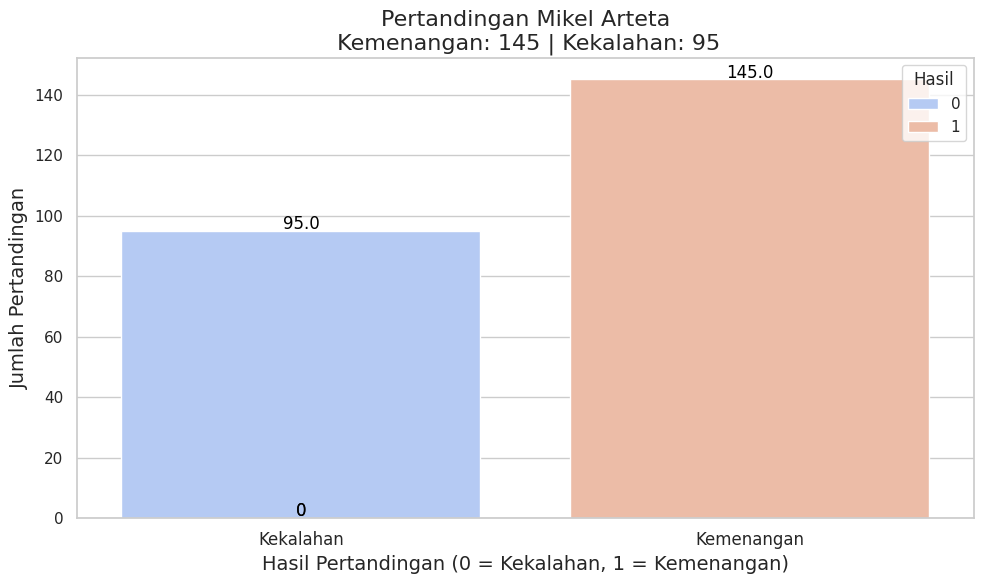

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataVisualization").getOrCreate()


# Baca data dari CSV
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast("integer")) \
       .withColumn("own_position", col("own_position").cast("integer")) \
       .withColumn("opponent_goals", col("opponent_goals").cast("integer")) \
       .withColumn("opponent_position", col("opponent_position").cast("integer")) \
       .withColumn("is_win", col("is_win").cast("integer"))

# Filter data untuk manajer Mikel Arteta
df_arteta = df.filter(df["own_manager_name"] == "Mikel Arteta")

# Convert ke Pandas untuk visualisasi
df_arteta_pd = df_arteta.toPandas()

# Hitung jumlah kemenangan dan kekalahan
win_count = df_arteta_pd['is_win'].sum()
loss_count = len(df_arteta_pd) - win_count

# Visualisasi menggunakan Seaborn
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Membuat countplot dengan lebih banyak informasi
ax = sns.countplot(data=df_arteta_pd, x='is_win', palette='coolwarm', hue='is_win')

# Mengatur detail grafik
ax.set_title(f'Pertandingan Mikel Arteta\n Kemenangan: {win_count} | Kekalahan: {loss_count}', fontsize=16)
ax.set_xlabel('Hasil Pertandingan (0 = Kekalahan, 1 = Kemenangan)', fontsize=14)
ax.set_ylabel('Jumlah Pertandingan', fontsize=14)
ax.set_xticklabels(['Kekalahan', 'Kemenangan'], fontsize=12)
ax.legend(title='Hasil', loc='upper right')

# Menambahkan nilai pada setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

# Menampilkan grafik
plt.tight_layout()
plt.show()


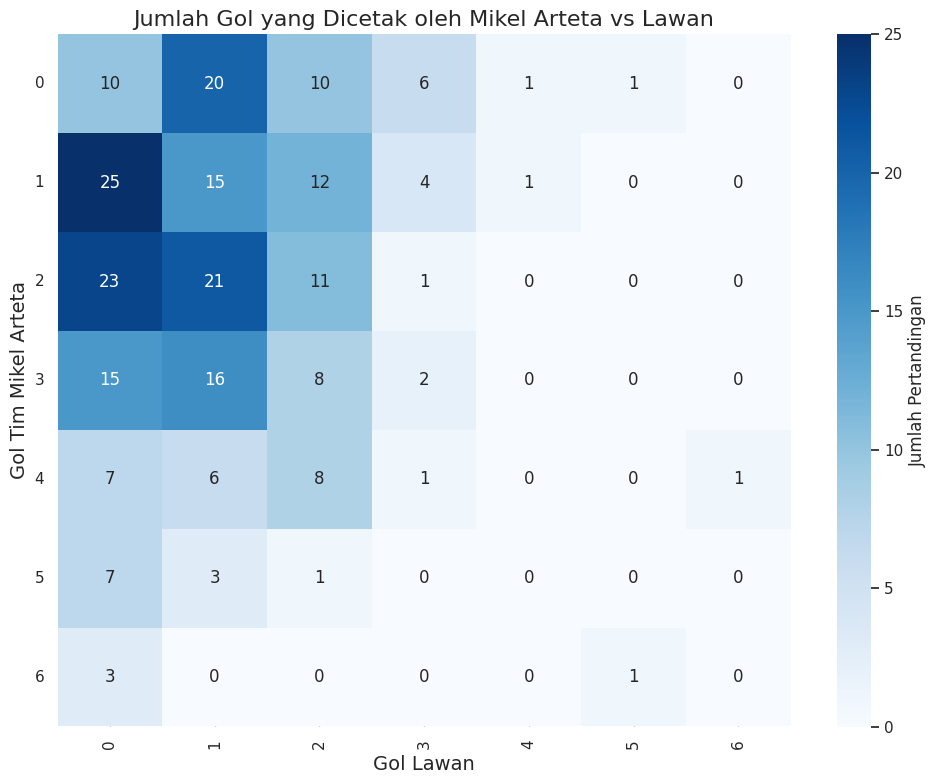

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataVisualization").getOrCreate()

# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast("integer")) \
       .withColumn("own_position", col("own_position").cast("integer")) \
       .withColumn("opponent_goals", col("opponent_goals").cast("integer")) \
       .withColumn("opponent_position", col("opponent_position").cast("integer"))

# Filter data untuk manajer Mikel Arteta
df_arteta = df.filter(df["own_manager_name"] == "Mikel Arteta")

# Convert ke Pandas untuk visualisasi
df_arteta_pd = df_arteta.toPandas()

# Hitung jumlah gol yang dicetak oleh Mikel Arteta dan tim lawannya
# Membuat DataFrame dengan jumlah gol
goals_data = df_arteta_pd[['own_goals', 'opponent_goals']]

# Membuat Pivot Table untuk Heatmap
# Kita akan menggunakan `own_goals` sebagai index dan `opponent_goals` sebagai columns
pivot_table = goals_data.pivot_table(index='own_goals', columns='opponent_goals', aggfunc='size', fill_value=0)

# Visualisasi menggunakan Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="Blues", fmt="g", cbar_kws={'label': 'Jumlah Pertandingan'})

# Menambahkan judul dan label
plt.title("Jumlah Gol yang Dicetak oleh Mikel Arteta vs Lawan", fontsize=16)
plt.xlabel("Gol Lawan", fontsize=14)
plt.ylabel("Gol Tim Mikel Arteta", fontsize=14)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()

# Tampilkan grafik
plt.show()


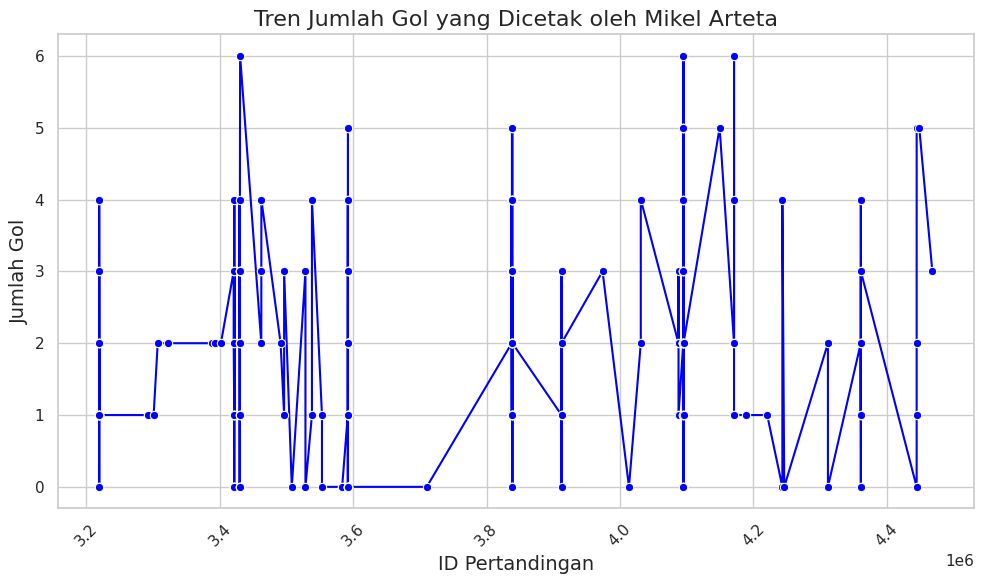

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("DataVisualization").getOrCreate()


# Cleaning data (ganti NaN dengan 0)
df = df.fillna({"own_goals": 0, "own_position": 0, "opponent_goals": 0, "opponent_position": 0})
df = df.withColumn("own_goals", col("own_goals").cast("integer")) \
       .withColumn("own_position", col("own_position").cast("integer")) \
       .withColumn("opponent_goals", col("opponent_goals").cast("integer")) \
       .withColumn("opponent_position", col("opponent_position").cast("integer"))

# Filter data untuk manajer Mikel Arteta
df_arteta = df.filter(df["own_manager_name"] == "Mikel Arteta")

# Convert ke Pandas untuk visualisasi
df_arteta_pd = df_arteta.toPandas()

# Pastikan kolom game_id (atau match_date) tersedia untuk digunakan sebagai sumbu-X
# Jika ada kolom tanggal, gunakan kolom tersebut. Jika tidak, kita dapat menggunakan game_id.

# Misalkan kita menggunakan game_id untuk menunjukkan urutan pertandingan
# Untuk membuat tren, kita akan mengurutkan data berdasarkan game_id
df_arteta_pd = df_arteta_pd.sort_values(by='game_id')

# Visualisasi menggunakan Line Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_arteta_pd, x='game_id', y='own_goals', marker='o', color='blue')

# Menambahkan judul dan label
plt.title("Tren Jumlah Gol yang Dicetak oleh Mikel Arteta", fontsize=16)
plt.xlabel("ID Pertandingan", fontsize=14)
plt.ylabel("Jumlah Gol", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

# Tampilkan grafik
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Membuat SparkSession
spark = SparkSession.builder \
    .appName("Prediksi Kemenangan Mikel Arteta") \
    .getOrCreate()


# Filter data untuk Mikel Arteta
df_arteta = df.filter(df["`own_manager_name`"] == "Mikel Arteta")

# Menyiapkan fitur dan label
feature_columns = ['own_goals', 'opponent_goals', 'own_position', 'opponent_position']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_features = assembler.transform(df_arteta)

# Pastikan tidak ada null pada label
df_cleaned = df_features.filter(df_features.is_win.isNotNull())

# Membagi data menjadi training dan testing
(train_df, test_df) = df_cleaned.randomSplit([0.8, 0.2], seed=42)

# Melatih model Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="is_win")
model = lr.fit(train_df)

# Membuat prediksi
predictions = model.transform(test_df)

# Evaluasi model
evaluator = MulticlassClassificationEvaluator(
    labelCol="is_win", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy:.2f}")

# Prediksi kemenangan dalam satu tahun ke depan
# Asumsikan rata-rata input fitur yang mungkin terjadi di tahun mendatang
future_data = spark.createDataFrame([
    (2, 1, 10, 12),  # Contoh data pertandingan
    (1, 2, 12, 10),
    (3, 0, 8, 15),
    (0, 2, 14, 8)
], feature_columns)

future_data_features = assembler.transform(future_data)
future_predictions = model.transform(future_data_features)

# Menampilkan prediksi
future_predictions.select("features", "prediction").show()


Accuracy: 1.00
+-------------------+----------+
|           features|prediction|
+-------------------+----------+
|[2.0,1.0,10.0,12.0]|       1.0|
|[1.0,2.0,12.0,10.0]|       0.0|
| [3.0,0.0,8.0,15.0]|       1.0|
| [0.0,2.0,14.0,8.0]|       0.0|
+-------------------+----------+



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


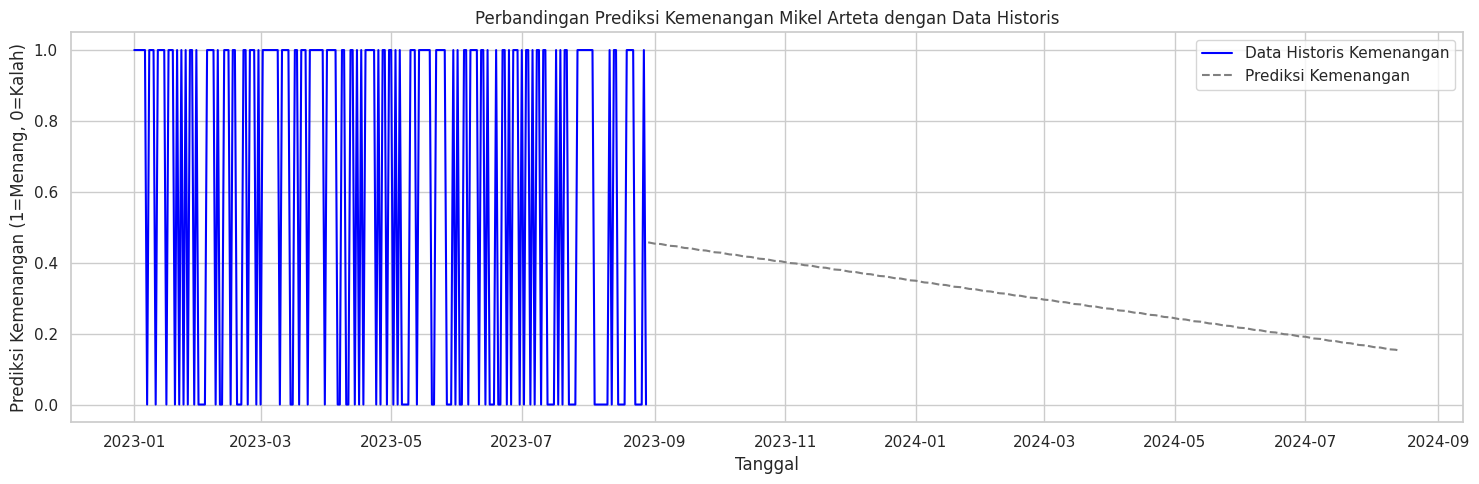

In [ ]:
# Jika game_id bukan tanggal dan tidak bisa diubah ke tanggal,
# Anda dapat membuat indeks berdasarkan urutan pertandingan.
df_arteta['date'] = pd.date_range(start='2023-01-01', periods=len(df_arteta), freq='D')

# Menyortir data berdasarkan urutan pertandingan dan 'date'
df_arteta = df_arteta.sort_values('date')

# Setel 'date' sebagai indeks
df_arteta.set_index('date', inplace=True)

# Melanjutkan dengan model dan visualisasi
model = ExponentialSmoothing(df_arteta['is_win'], trend='add').fit()

# Prediksi untuk 1 tahun ke depan (252 hari kerja)
hariKerja = 252
prediksi = model.forecast(steps=hariKerja)

# Membuat indeks tanggal untuk prediksi
tanggalPrediksi = pd.date_range(start=df_arteta.index[-1], periods=hariKerja + 1, freq='B')[1:]
dataFramePrediksi = pd.DataFrame({'Date': tanggalPrediksi, 'prediksiWin': prediksi.values})
dataFramePrediksi.set_index('Date', inplace=True)

# Visualisasi
plt.figure(figsize=(15, 5))

# Data historis
plt.plot(df_arteta['is_win'], label='Data Historis Kemenangan', color='blue', linestyle='-')

# Prediksi kemenangan Mikel Arteta
plt.plot(dataFramePrediksi['prediksiWin'], label='Prediksi Kemenangan', color='grey', linestyle='--')

# Menambahkan judul dan label
plt.title('Perbandingan Prediksi Kemenangan Mikel Arteta dengan Data Historis')
plt.xlabel('Tanggal')
plt.ylabel('Prediksi Kemenangan (1=Menang, 0=Kalah)')
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


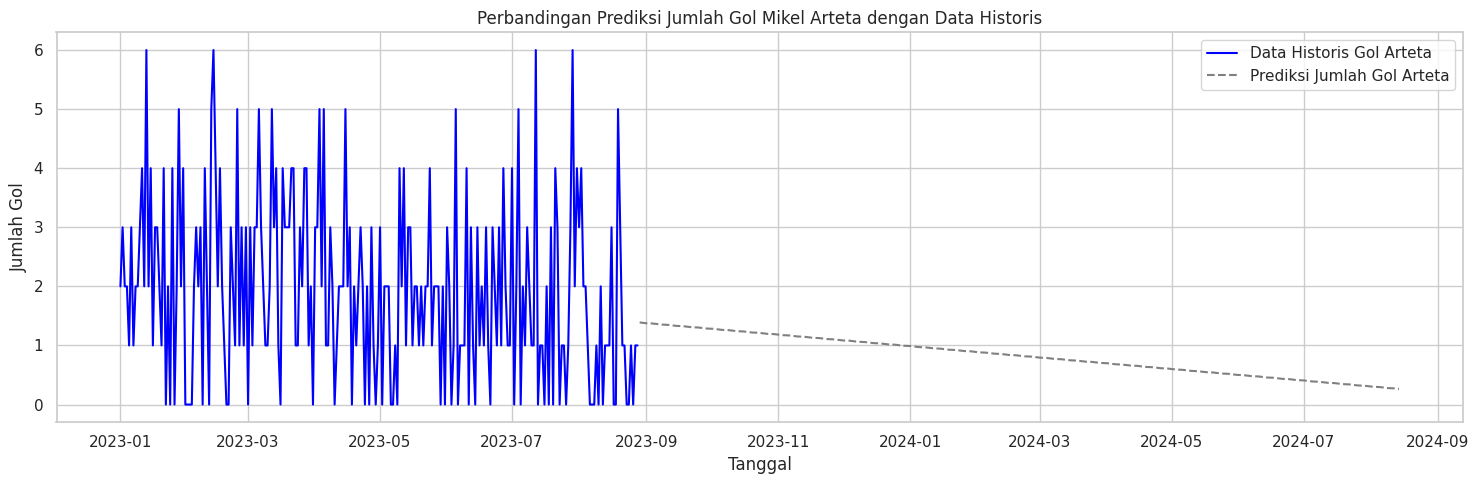

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Misalnya, Anda sudah memiliki df_arteta sebagai DataFrame pandas
# Jika df_arteta adalah DataFrame Spark, Anda harus mengubahnya menjadi pandas:
df_arteta = df_arteta.toPandas()  # Jika data berasal dari Spark DataFrame

# Menyusun data dengan urutan pertandingan
df_arteta['date'] = pd.date_range(start='2023-01-01', periods=len(df_arteta), freq='D')

# Menyortir data berdasarkan urutan pertandingan dan 'date'
df_arteta = df_arteta.sort_values('date')

# Setel 'date' sebagai indeks
df_arteta.set_index('date', inplace=True)

# Melatih model Exponential Smoothing untuk prediksi jumlah gol
model = ExponentialSmoothing(df_arteta['own_goals'], trend='add').fit()

# Prediksi untuk 1 tahun ke depan (252 hari kerja)
hariKerja = 252
prediksi = model.forecast(steps=hariKerja)

# Membuat indeks tanggal untuk prediksi
tanggalPrediksi = pd.date_range(start=df_arteta.index[-1], periods=hariKerja + 1, freq='B')[1:]
dataFramePrediksi = pd.DataFrame({'Date': tanggalPrediksi, 'prediksiGol': prediksi.values})
dataFramePrediksi.set_index('Date', inplace=True)

# Visualisasi
plt.figure(figsize=(15, 5))

# Data historis jumlah gol
plt.plot(df_arteta['own_goals'], label='Data Historis Gol Arteta', color='blue', linestyle='-')

# Prediksi jumlah gol Arteta
plt.plot(dataFramePrediksi['prediksiGol'], label='Prediksi Jumlah Gol Arteta', color='grey', linestyle='--')

# Menambahkan judul dan label
plt.title('Perbandingan Prediksi Jumlah Gol Mikel Arteta dengan Data Historis')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Gol')
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-13-35671297876e>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  arteta_data['own_position'].fillna(arteta_data['own_position'].median(), inplace=True)
<ipython-input-13-35671297876e>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arteta_data['own_position'].fillna(arteta_data['own_position'].median(), inplace=True)
<ipytho

Accuracy: 0.9166666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92        26
           1       0.88      0.95      0.91        22

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



<ipython-input-13-35671297876e>:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Prediction', data=future_matches, palette='Set2')


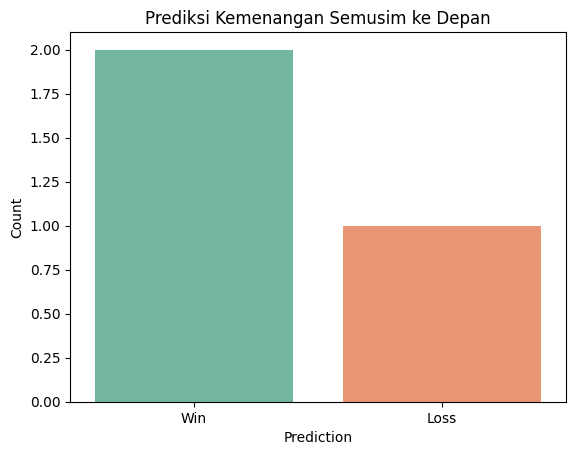

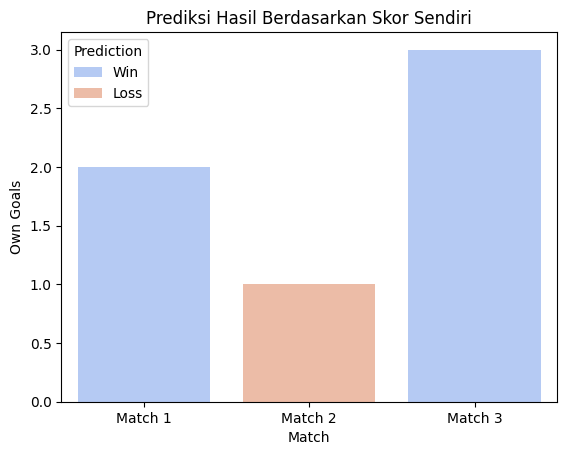

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# **1. Load Data**
data = pd.read_csv('dataset.csv')

# **2. Filter Data untuk Mikel Arteta**
arteta_data = data[data['own_manager_name'] == 'Mikel Arteta']

# **3. Data Cleaning**
arteta_data['own_position'].fillna(arteta_data['own_position'].median(), inplace=True)
arteta_data['opponent_position'].fillna(arteta_data['opponent_position'].median(), inplace=True)
arteta_data['own_goals'].fillna(0, inplace=True)
arteta_data['opponent_goals'].fillna(0, inplace=True)

# Menghapus kolom yang tidak relevan untuk prediksi
arteta_data = arteta_data.drop(['game_id', 'own_manager_name', 'opponent_manager_name'], axis=1)

# **4. Feature Engineering**
X = arteta_data.drop(['is_win'], axis=1)  # Input features
y = arteta_data['is_win']  # Target variable

# Konversi kolom kategorikal menjadi numerik
X = pd.get_dummies(X, columns=['hosting', 'club_id', 'opponent_id'])

# **5. Split Data**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **6. Model Building**
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# **7. Evaluasi Model**
y_pred = model.predict(X_test)

# Akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# **8. Prediksi Semusim ke Depan**
future_matches = pd.DataFrame({
    'own_goals': [2, 1, 3],
    'opponent_goals': [1, 2, 0],
    'own_position': [1, 2, 3],
    'opponent_position': [5, 10, 15],
    'hosting': ['Home', 'Away', 'Home'],
    'club_id': [1468, 1468, 1468],
    'opponent_id': [23, 86, 1059]
})

# Konversi data baru ke format numerik
future_matches = pd.get_dummies(future_matches, columns=['hosting', 'club_id', 'opponent_id'])

# Pastikan kolomnya cocok dengan model
future_matches = future_matches.reindex(columns=X.columns, fill_value=0)

# Prediksi hasil
predictions = model.predict(future_matches)

# Tambahkan prediksi ke dataset future_matches
future_matches['Prediction'] = predictions
future_matches['Prediction'] = future_matches['Prediction'].map({0: 'Loss', 1: 'Win'})

# **9. Visualisasi Prediksi**
# Plot distribusi prediksi
sns.countplot(x='Prediction', data=future_matches, palette='Set2')
plt.title('Prediksi Kemenangan Semusim ke Depan')
plt.xlabel('Prediction')
plt.ylabel('Count')
plt.show()

# Visualisasi Detail Pertandingan dengan Prediksi
future_matches['Match'] = [f'Match {i+1}' for i in range(len(future_matches))]
sns.barplot(x='Match', y='own_goals', hue='Prediction', data=future_matches, palette='coolwarm')
plt.title('Prediksi Hasil Berdasarkan Skor Sendiri')
plt.xlabel('Match')
plt.ylabel('Own Goals')
plt.show()


<ipython-input-16-05f8ac30b294>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  arteta_data['own_position'].fillna(arteta_data['own_position'].median(), inplace=True)
<ipython-input-16-05f8ac30b294>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arteta_data['own_position'].fillna(arteta_data['own_position'].median(), inplace=True)
<ipytho

Accuracy: 0.9166666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.88      0.92        26
           1       0.88      0.95      0.91        22

    accuracy                           0.92        48
   macro avg       0.92      0.92      0.92        48
weighted avg       0.92      0.92      0.92        48



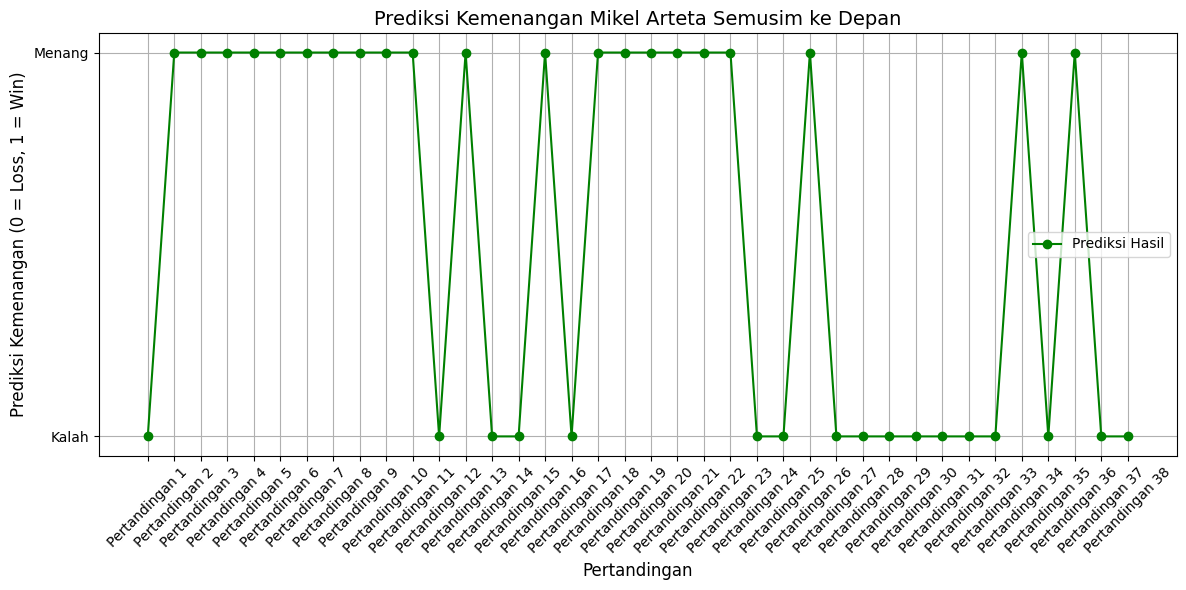

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# **1. Load Data**
data = pd.read_csv('dataset.csv')

# **2. Filter Data untuk Mikel Arteta**
arteta_data = data[data['own_manager_name'] == 'Mikel Arteta']

# **3. Data Cleaning**
arteta_data['own_position'].fillna(arteta_data['own_position'].median(), inplace=True)
arteta_data['opponent_position'].fillna(arteta_data['opponent_position'].median(), inplace=True)
arteta_data['own_goals'].fillna(0, inplace=True)
arteta_data['opponent_goals'].fillna(0, inplace=True)

# Menghapus kolom yang tidak relevan untuk prediksi
arteta_data = arteta_data.drop(['game_id', 'own_manager_name', 'opponent_manager_name'], axis=1)

# **4. Feature Engineering**
X = arteta_data.drop(['is_win'], axis=1)  # Input features
y = arteta_data['is_win']  # Target variable

# Konversi kolom kategorikal menjadi numerik
X = pd.get_dummies(X, columns=['hosting', 'club_id', 'opponent_id'])

# **5. Split Data**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **6. Model Building**
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# **7. Evaluasi Model**
y_pred = model.predict(X_test)

# Akurasi
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# **8. Prediksi Semusim ke Depan**
# Simulasi 38 pertandingan untuk satu musim
# Misalnya data berikut menunjukkan beberapa informasi yang relevan untuk prediksi
future_matches = pd.DataFrame({
    'own_goals': np.random.randint(0, 5, size=38),  # Random goals (simulasi)
    'opponent_goals': np.random.randint(0, 5, size=38),  # Random goals (simulasi)
    'own_position': np.random.randint(1, 20, size=38),  # Random posisi tim
    'opponent_position': np.random.randint(1, 20, size=38),  # Random posisi lawan
    'hosting': np.random.choice(['Home', 'Away'], size=38),  # Home/Away match
    'club_id': [1468] * 38,  # ID tim Arteta
    'opponent_id': np.random.randint(1, 3000, size=38)  # Random opponent ID
})

# Konversi data baru ke format numerik
future_matches = pd.get_dummies(future_matches, columns=['hosting', 'club_id', 'opponent_id'])

# Pastikan kolomnya cocok dengan model
future_matches = future_matches.reindex(columns=X.columns, fill_value=0)

# Prediksi hasil
predictions = model.predict(future_matches)

# Tambahkan prediksi ke dataset future_matches
future_matches['Prediction'] = predictions
future_matches['Prediction'] = future_matches['Prediction'].map({0: 'Loss', 1: 'Win'})

# **9. Visualisasi Grafik Garis Seperti Saham**
plt.figure(figsize=(12, 6))

# Grafik garis untuk prediksi kemenangan dan kekalahan
plt.plot(future_matches.index, predictions, label='Prediksi Hasil', color='green', marker='o', linestyle='-', markersize=6)

# Label untuk grafik
plt.title('Prediksi Kemenangan Mikel Arteta Semusim ke Depan', fontsize=14)
plt.xlabel('Pertandingan', fontsize=12)
plt.ylabel('Prediksi Kemenangan (0 = Loss, 1 = Win)', fontsize=12)
plt.xticks(future_matches.index, labels=[f'Pertandingan {i+1}' for i in range(len(future_matches))], rotation=45)
plt.yticks([0, 1], labels=['Kalah', 'Menang'])
plt.grid(True)

# Menampilkan grafik
plt.legend()
plt.tight_layout()
plt.show()
